In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


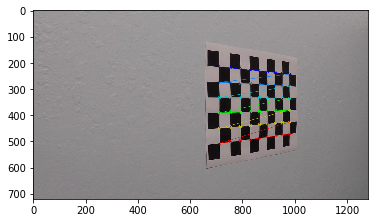

In [2]:
import glob
images = glob.glob('/Users/kathan/udacity/Term-1/CarND-Term1-Starter-Kit/Advance Lane Finding/CarND-Advanced-Lane-Lines-master/camera_cal/calibration*.jpg')

objpoints = [] #3D points in real world space
imgpoints = [] #2D points in image plane
nx = 6 #enter the number of inside corners in x
ny = 9 #enter the number of inside corners in y


#Prepare object points like (0,0,0),(1,0,0) etc..
objp = np.zeros((6*9,3),np.float32)
#Third column will always be zero. No need to change. Need to populate x and y column. Use mgrid of numpy.
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)#x,y coordinate

#Now we have to create image points. For that we have to detect the corners of the board.

for fname in images:
    #print (fname)
    
    image = cv2.imread(fname)
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

    #If there is any corner point then append it to image point array.
    #Also add prepared obj points to object point array
    #These object points are same for for all of the calibration images as they represent  read chessboard
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

        #Display these corner points on an image
        cv2.drawChessboardCorners(image, (9, 6), corners, ret)
        plt.imshow(image)


    

In [ ]:
print (len(imgpoints))
print (len(objpoints))

In [3]:
#Calibration of camera using object points and image points. It retruns camera matrix and distortion coeff in mtx
#and dist variable resp.
#rvecs and tvecs containts position of camera in real world
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [ ]:
#Now undistort an image
#dst = cv2.undistort(img, mtx, dist, None, mtx)

In [ ]:

#f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
#f.tight_layout()
#ax1.imshow(img)
#ax1.set_title('Original Image', fontsize=50)
#ax2.imshow(dst)
#ax2.set_title('Undistorted Image', fontsize=50)
#plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [217]:
def undistort_image(img,mat,dist):
    return cv2.undistort(img,mat,dist,None,mat)

def threshold_image(img):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    hsv1 = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    h_hsv_channel1 = hsv1[:,:,0]
    s_hsv_channel1 = hsv1[:,:,1]
    v_hsv_channel1 = hsv1[:,:,2]

    r = img[:,:,0]
    g = img[:,:,1]
    b = img[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray1 = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx1 = cv2.Sobel(gray1, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx1 = np.absolute(sobelx1) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel1 = np.uint8(255*abs_sobelx1/np.max(abs_sobelx1))

    # Threshold x gradient
    #thresh_min1 = 24
    #thresh_max1 = 110
    #thresh_min1 = 40
    #thresh_max1 = 100
    thresh_min1 = 38
    thresh_max1 = 100
    
    sxbinary1 = np.zeros_like(scaled_sobel1)
    sxbinary1[(scaled_sobel1 >= thresh_min1) & (scaled_sobel1 <= thresh_max1)] = 1

    # Threshold color channel
    #s_thresh_min1 = 165
    #s_thresh_max1 = 254
    #s_thresh_min1 = 160
    #s_thresh_max1 = 254
    s_thresh_min1 = 165
    s_thresh_max1 = 190
    
    
    s_binary1 = np.zeros_like(s_channel)
    s_binary1[(s_channel >= s_thresh_min1) & (s_channel <= s_thresh_max1)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary1 = np.dstack(( np.zeros_like(sxbinary1), sxbinary1, s_binary1)) * 255

    # Combine the two binary thresholds
    combined_binary1 = np.zeros_like(sxbinary1)
    combined_binary1[(s_binary1 == 1) | (sxbinary1 == 1)] = 1
    
    return combined_binary1,color_binary1

def transform_image(img):
    
    src_points = np.float32([[705,460],[1110,720],[205,720],[580,460]])
    dst_points = np.float32([[960,0],[960,720],[320,720],[320,0]])
    img_size = (img.shape[1],img.shape[0])
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    Minv = cv2.getPerspectiveTransform(dst_points,src_points)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped,Minv


def find_histogram(img):
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]/2)
    print (midpoint)

    leftx_base = np.argmax(histogram[:midpoint])
    print (leftx_base)

    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    print (rightx_base)
    
    return histogram,midpoint,leftx_base,rightx_base


def find_lanes(img,out_img,leftx_base,rightx_base):
    #Choose the number of sliding windows
    nwindows = 9

    #Set height of windows
    window_height = np.int(img.shape[0]/nwindows)

    #Identify x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    #minpix = 50
    minpix = 10
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    return left_fitx,right_fitx,left_lane_inds,right_lane_inds,nonzerox,nonzeroy,ploty

def visualize_lane_lines(img,out_img,left_fitx,right_fitx,left_lane_inds,right_lane_inds,nonzerox,nonzeroy,ploty):
    # Create an image to draw on and an image to show the selection window
    #margin = 100
    margin = 60
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    out_img = np.dstack((img, img, img))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)


def merged_image(img,original,Minv,left_fitx,right_fitx,ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(original, 1, newwarp, 0.3, 0)
    plt.imshow(result)
    return result
    
    
    



(720, 1280, 3)


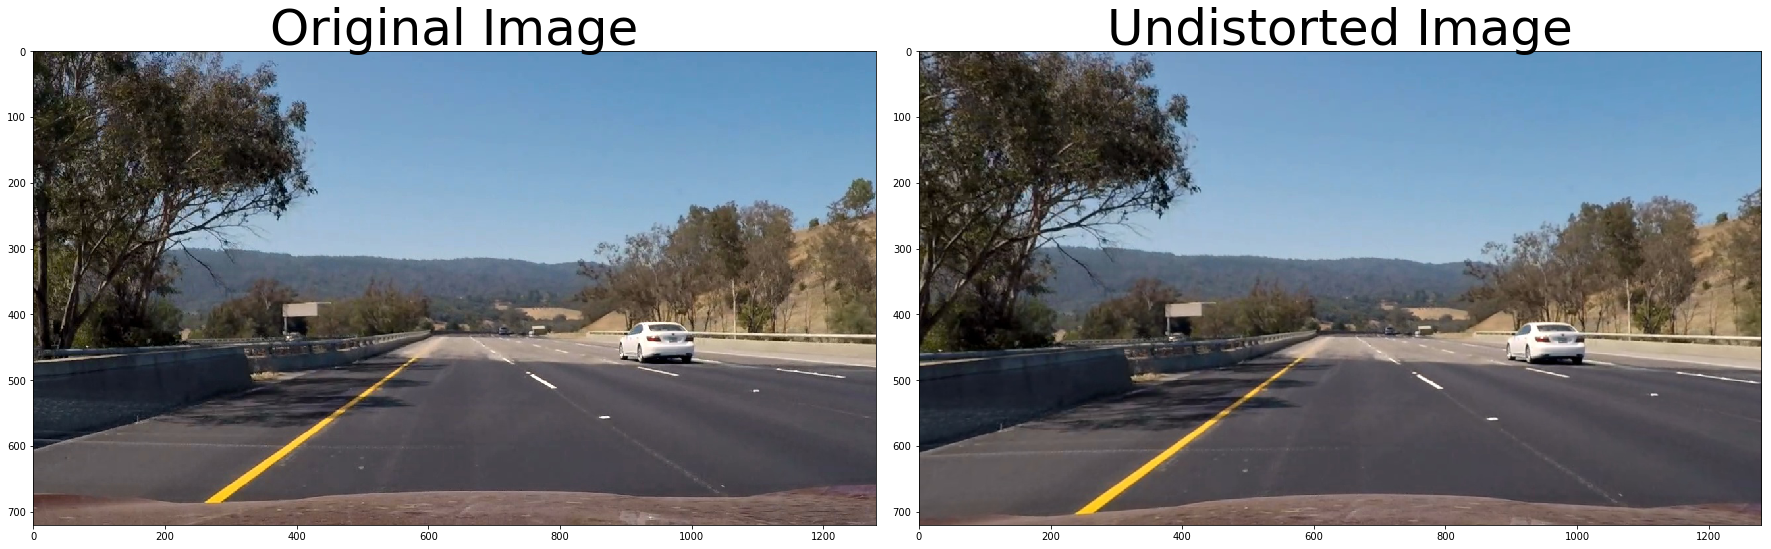

In [218]:
#test1 = mpimg.imread('/Users/kathan/udacity/Term-1/CarND-Term1-Starter-Kit/Advance Lane Finding/CarND-Advanced-Lane-Lines-master/test_images/test4.jpg')
test1 = mpimg.imread('/Users/kathan/udacity/Term-1/CarND-Term1-Starter-Kit/Advance Lane Finding/CarND-Advanced-Lane-Lines-master/frame530.jpg')
print (test1.shape)


#test_dst = cv2.undistort(test1, mtx, dist, None, mtx)
test_dst = undistort_image(test1,mtx,dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test1)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(test_dst)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

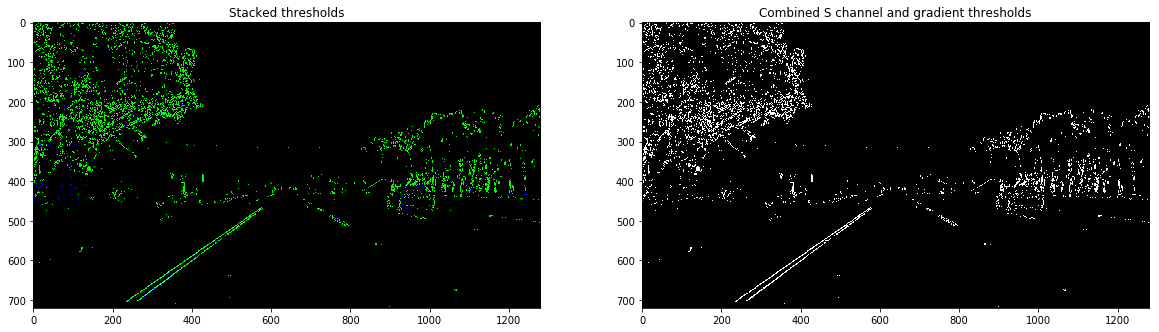

In [219]:

combined,color = threshold_image(test_dst)
# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color)
ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined, cmap='gray')



In [220]:
#straight_image = mpimg.imread('/Users/kathan/udacity/Term-1/CarND-Term1-Starter-Kit/Advance Lane Finding/CarND-Advanced-Lane-Lines-master/test_images/straight_lines1.jpg')

#plt.imshow(straight_image)
#plt.plot(705,460,'.') #Top right
#plt.plot(1110,720,'.') #Bottom right
#plt.plot(205,720,'.') #Bottom left
#plt.plot(580,460,'.') #Top left




In [221]:
#straight_image_dst = cv2.undistort(straight_image, mtx, dist, None, mtx)
#src_points = np.float32([[705,460],[1110,720],[205,720],[580,460]])
##src_points = np.float32([[695,460],[1127,720],[203,720],[585,460]])
#dst_points = np.float32([[960,0],[960,720],[320,720],[320,0]])
##dst_points = np.float32([[960,0],[960,720],[320,720],[320,0]])

#img_size = (straight_image.shape[1],straight_image.shape[0])
#M1 = cv2.getPerspectiveTransform(src_points, dst_points)
#Minv1 = cv2.getPerspectiveTransform(dst_points,src_points)
#straight_warped = cv2.warpPerspective(straight_image_dst, M1, img_size, flags=cv2.INTER_LINEAR)

#plt.imshow(straight_warped)




In [222]:
#plt.imshow(test1)
#plt.plot(700,450,'.') #Top right
#plt.plot(1130,720,'.') #Bottom right
#plt.plot(180,720,'.') #Bottom left
#plt.plot(580,450,'.') #Top left



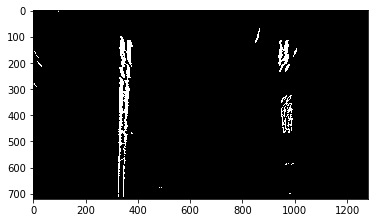

In [223]:
#src_points = np.float32([[700,450],[1130,720],[180,720],[580,450]])
#dst_points = np.float32([[960,0],[960,720],[360,720],[360,0]])

warped_image,Minv = transform_image(combined)
plt.imshow(warped_image,cmap='gray')



640
330
977


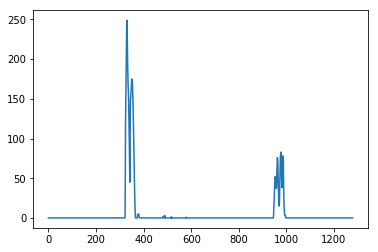

In [224]:
histogram_image,midpoint,leftx_base,rightx_base = find_histogram(warped_image)
plt.plot(histogram_image)

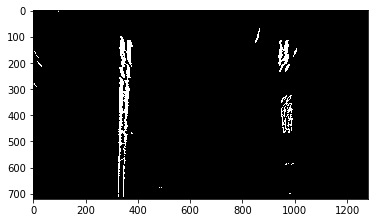

In [225]:
# Create an output image to draw on and  visualize the result
out_img = np.dstack((warped_image, warped_image, warped_image))*255

plt.imshow(out_img)



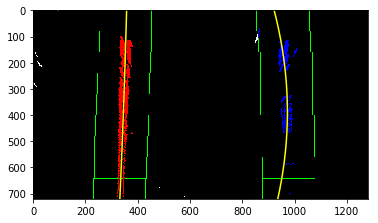

In [226]:
left_fitx,right_fitx,left_lane_inds,right_lane_inds,nonzerox,nonzeroy,ploty = find_lanes(warped_image,out_img,leftx_base,rightx_base)

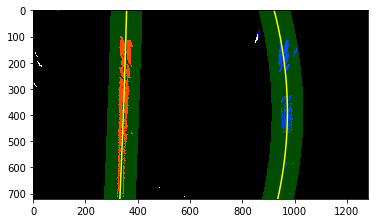

In [227]:

visualize_lane_lines(warped_image,out_img,left_fitx,right_fitx,left_lane_inds,right_lane_inds,nonzerox,nonzeroy,ploty)

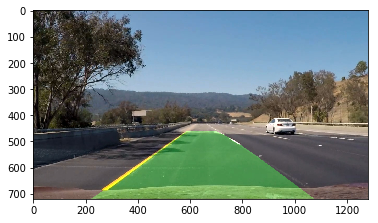

In [228]:
final_image = merged_image(warped_image,test1,Minv,left_fitx,right_fitx,ploty)

In [229]:
##Code to Store video in frames

#import cv2
#vidcap = cv2.VideoCapture('project_video.mp4')
#success,image = vidcap.read()
#count = 0
#success = True
#while success:
#    success,image = vidcap.read()
#    print('Read a new frame: ', success)
#    cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file
#    count += 1

In [230]:
def process_image(img):
    undist = undistort_image(img,mtx,dist)
    combined,color = threshold_image(undist)
    
    warped_image,Minv = transform_image(combined)
    histogram_image,midpoint,leftx_base,rightx_base = find_histogram(warped_image)
    out_img = np.dstack((warped_image, warped_image, warped_image))*255
    left_fitx,right_fitx,left_lane_inds,right_lane_inds,nonzerox,nonzeroy,ploty = find_lanes(warped_image,out_img,leftx_base,rightx_base)
    final_result = merged_image(warped_image,img,Minv,left_fitx,right_fitx,ploty)
    return final_result
    
    
    

In [231]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

640
18
1008
[MoviePy] >>>> Building video output_video/project_video_output_trial3.mp4
[MoviePy] Writing video output_video/project_video_output_trial3.mp4


  0%|          | 0/151 [00:00<?, ?it/s]

640

  1%|          | 1/151 [00:00<00:22,  6.65it/s]


18
1008
640
339
1021


  1%|▏         | 2/151 [00:00<00:22,  6.62it/s]

640
329
1028


  2%|▏         | 3/151 [00:00<00:21,  6.82it/s]

640
319
1034


  3%|▎         | 4/151 [00:00<00:21,  6.88it/s]

640
320
1035


  3%|▎         | 5/151 [00:00<00:20,  7.02it/s]

640
18
1005


  4%|▍         | 6/151 [00:00<00:20,  6.98it/s]

640
21
1007


  5%|▍         | 7/151 [00:01<00:21,  6.76it/s]

640
351
994


  5%|▌         | 8/151 [00:01<00:21,  6.69it/s]

640
345
991


  6%|▌         | 9/151 [00:01<00:22,  6.32it/s]

640
335
989


  7%|▋         | 10/151 [00:01<00:22,  6.20it/s]

640
329
983


  7%|▋         | 11/151 [00:01<00:22,  6.12it/s]

640
0
985


  8%|▊         | 12/151 [00:01<00:22,  6.17it/s]

640
321
981


  9%|▊         | 13/151 [00:02<00:23,  5.87it/s]

640

  9%|▉         | 14/151 [00:02<00:23,  5.78it/s]


321
1000
640
316
1001


 10%|▉         | 15/151 [00:02<00:22,  6.06it/s]

640
318
1014


 11%|█         | 16/151 [00:02<00:21,  6.19it/s]

640
316
992


 11%|█▏        | 17/151 [00:02<00:21,  6.28it/s]

640
317
983


 12%|█▏        | 18/151 [00:02<00:21,  6.31it/s]

640
316
983


 13%|█▎        | 19/151 [00:02<00:20,  6.48it/s]

640
315
984


 13%|█▎        | 20/151 [00:03<00:19,  6.70it/s]

640
318
978


 14%|█▍        | 21/151 [00:03<00:20,  6.36it/s]

640
314
978


 15%|█▍        | 22/151 [00:03<00:20,  6.17it/s]

640
309
976


 15%|█▌        | 23/151 [00:03<00:20,  6.33it/s]

640
306
976


 16%|█▌        | 24/151 [00:03<00:19,  6.43it/s]

640
286
977


 17%|█▋        | 25/151 [00:03<00:19,  6.54it/s]

640
306
1003


 17%|█▋        | 26/151 [00:04<00:19,  6.36it/s]

640
307
996


 18%|█▊        | 27/151 [00:04<00:18,  6.70it/s]

640
309
987


 19%|█▉        | 29/151 [00:04<00:17,  7.05it/s]

640
310
999
640
308
997


 20%|█▉        | 30/151 [00:04<00:17,  7.03it/s]

640
307
993


 21%|██        | 31/151 [00:04<00:17,  6.98it/s]

640
305
991


 21%|██        | 32/151 [00:04<00:17,  6.99it/s]

640
302
992


 22%|██▏       | 33/151 [00:05<00:16,  7.14it/s]

640
305
989


 23%|██▎       | 34/151 [00:05<00:16,  7.21it/s]

640
307
988


 23%|██▎       | 35/151 [00:05<00:16,  7.21it/s]

640
309
976


 24%|██▍       | 36/151 [00:05<00:16,  7.17it/s]

640
311
976


 25%|██▍       | 37/151 [00:05<00:16,  7.12it/s]

640
310
991


 25%|██▌       | 38/151 [00:05<00:16,  6.92it/s]

640
310
984


 26%|██▌       | 39/151 [00:05<00:16,  6.90it/s]

640
306
988


 26%|██▋       | 40/151 [00:06<00:16,  6.87it/s]

640
325
987


 27%|██▋       | 41/151 [00:06<00:16,  6.79it/s]

640
321
982


 28%|██▊       | 42/151 [00:06<00:16,  6.73it/s]

640
318
981


 29%|██▉       | 44/151 [00:06<00:18,  5.63it/s]

640
315
960
640
329
964


 30%|███       | 46/151 [00:07<00:18,  5.61it/s]

640
339
954
640
328
1012


 32%|███▏      | 48/151 [00:07<00:18,  5.63it/s]

640
311
1002
640
305
1025


 33%|███▎      | 50/151 [00:07<00:16,  6.09it/s]

640
301
1021
640
303
1008


 34%|███▍      | 52/151 [00:08<00:16,  6.19it/s]

640
305
1003
640
300
1000


 36%|███▌      | 54/151 [00:08<00:18,  5.35it/s]

640
328
994


 36%|███▋      | 55/151 [00:08<00:18,  5.26it/s]

640
344
989
640
343
988


 38%|███▊      | 57/151 [00:09<00:18,  5.21it/s]

640
362
965


 38%|███▊      | 58/151 [00:09<00:17,  5.19it/s]

640
361
986
640
368
982


 40%|███▉      | 60/151 [00:09<00:17,  5.24it/s]

640
383
992
640
393
985


 41%|████      | 62/151 [00:10<00:16,  5.34it/s]

640
385
987
640
369
997


 42%|████▏     | 64/151 [00:10<00:16,  5.29it/s]

640
357
982
640
349
1006


 44%|████▎     | 66/151 [00:10<00:16,  5.26it/s]

640
343
1007
640
348
1003


 45%|████▌     | 68/151 [00:11<00:15,  5.42it/s]

640
354
1002
640
358
1001


 46%|████▋     | 70/151 [00:11<00:15,  5.33it/s]

640
356
1002
640
360
1010


 48%|████▊     | 72/151 [00:11<00:15,  5.24it/s]

640
360
1029
640
359
1005


 49%|████▉     | 74/151 [00:12<00:14,  5.45it/s]

640
364
999
640
367
994


 50%|█████     | 76/151 [00:12<00:12,  6.04it/s]

640
366
995
640
374
1007


 52%|█████▏    | 78/151 [00:12<00:13,  5.33it/s]

640
378
986


 52%|█████▏    | 79/151 [00:13<00:13,  5.18it/s]

640
373
1007
640

 54%|█████▎    | 81/151 [00:13<00:13,  5.21it/s]


371
986
640
365
1010
640
370
1041


 55%|█████▍    | 83/151 [00:13<00:12,  5.24it/s]

640
368
1054
640
374
1053


 56%|█████▋    | 85/151 [00:14<00:12,  5.33it/s]

640
372
1045
640
368
1025


 58%|█████▊    | 87/151 [00:14<00:11,  5.79it/s]

640
368
1017
640
368
1031


 59%|█████▉    | 89/151 [00:14<00:10,  5.93it/s]

640
369
1027
640
375
1019


 60%|██████    | 91/151 [00:15<00:10,  5.79it/s]

640
370
1016
640
371
1015


 62%|██████▏   | 93/151 [00:15<00:09,  6.26it/s]

640
369
1019
640
366
1048


 63%|██████▎   | 95/151 [00:15<00:08,  6.41it/s]

640
375
1042
640
374
1034


 64%|██████▍   | 97/151 [00:16<00:08,  6.50it/s]

640
374
1029
640
381
1024


 66%|██████▌   | 99/151 [00:16<00:08,  6.39it/s]

640
382
1002
640
382
1020


 67%|██████▋   | 101/151 [00:16<00:07,  6.56it/s]

640
381
1019
640
374
1023


 68%|██████▊   | 103/151 [00:17<00:07,  6.53it/s]

640
379
1020
640
376
1022


 70%|██████▉   | 105/151 [00:17<00:07,  6.31it/s]

640
376
1037
640
383
1033


 71%|███████   | 107/151 [00:17<00:07,  6.15it/s]

640
374
1060
640
380
1051


 72%|███████▏  | 109/151 [00:18<00:06,  6.16it/s]

640
370
1051
640
365
1045


 74%|███████▎  | 111/151 [00:18<00:06,  6.43it/s]

640
388
1035
640
384
1033


 75%|███████▍  | 113/151 [00:18<00:05,  6.53it/s]

640
384
1026
640
382
1023


 76%|███████▌  | 115/151 [00:18<00:05,  6.60it/s]

640
360
1023
640
383
1001


 77%|███████▋  | 117/151 [00:19<00:05,  6.68it/s]

640
384
999
640
382
996


 79%|███████▉  | 119/151 [00:19<00:04,  6.73it/s]

640
381
1018
640
377
997


 80%|████████  | 121/151 [00:19<00:04,  6.29it/s]

640
376
996
640
365
999


 81%|████████▏ | 123/151 [00:20<00:04,  6.36it/s]

640
358
1024
640
362
1019


 83%|████████▎ | 125/151 [00:20<00:03,  6.55it/s]

640
357
1019
640
358
996


 84%|████████▍ | 127/151 [00:20<00:03,  6.52it/s]

640
358
1012
640
354
1026


 85%|████████▌ | 129/151 [00:21<00:03,  6.68it/s]

640
358
1050
640
360
1015


 87%|████████▋ | 131/151 [00:21<00:03,  6.15it/s]

640
357
1037
640
358
1021


 88%|████████▊ | 133/151 [00:21<00:02,  6.38it/s]

640
352
1027
640
352
1021


 89%|████████▉ | 135/151 [00:22<00:02,  6.34it/s]

640
351
1016
640
370
1009


 91%|█████████ | 137/151 [00:22<00:02,  6.50it/s]

640
370
986
640
369
1010


 92%|█████████▏| 139/151 [00:22<00:01,  6.53it/s]

640
368
1007
640
368
1002


 93%|█████████▎| 141/151 [00:22<00:01,  6.58it/s]

640
366
1035
640
367
1026


 95%|█████████▍| 143/151 [00:23<00:01,  6.75it/s]

640
367
1024
640
368
1022


 96%|█████████▌| 145/151 [00:23<00:00,  6.79it/s]

640
373
1013
640
370
1015


 97%|█████████▋| 147/151 [00:23<00:00,  6.65it/s]

640
369
1015
640
370
1009


 99%|█████████▊| 149/151 [00:24<00:00,  6.74it/s]

640
384
1011
640
360
1012


 99%|█████████▉| 150/151 [00:24<00:00,  6.69it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/project_video_output_trial3.mp4 

CPU times: user 26.7 s, sys: 3.82 s, total: 30.5 s
Wall time: 25.3 s


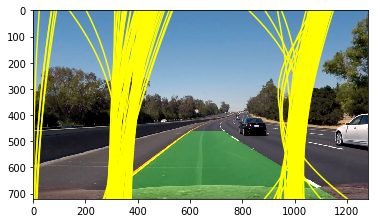

In [232]:
white_output = 'output_video/project_video_output_trial3.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4").subclip(40,46)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
